In [9]:
pip install pandas numpy scikit-learn joblib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


O2: MSE = 22.22, R2 = -0.02
NO3: MSE = 18.15, R2 = 0.52
NO2: MSE = 10.61, R2 = -78.42
SO4: MSE = 2412.14, R2 = 0.41
PO4: MSE = 0.38, R2 = 0.32
CL: MSE = 34882.81, R2 = 0.74

🌍 Predicted Pollutant Levels:
O2: 12.60
NO3: 6.90
NO2: 0.13
SO4: 143.08
PO4: 0.50
CL: 67.33


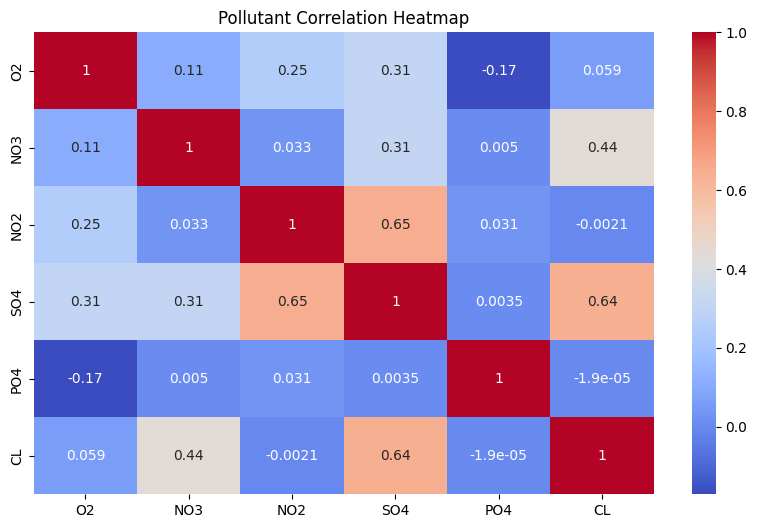

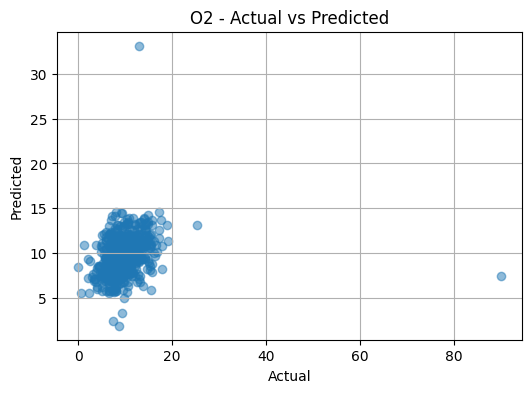

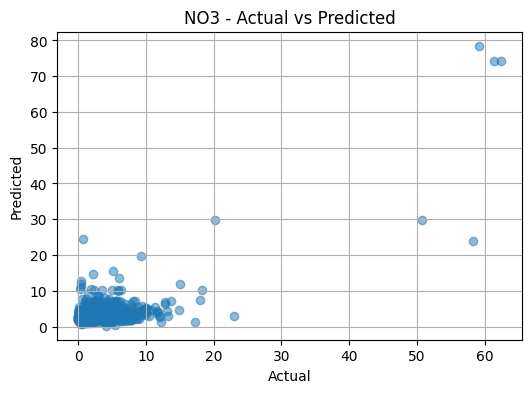

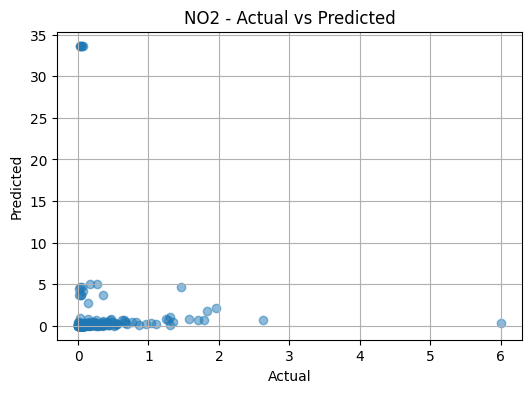

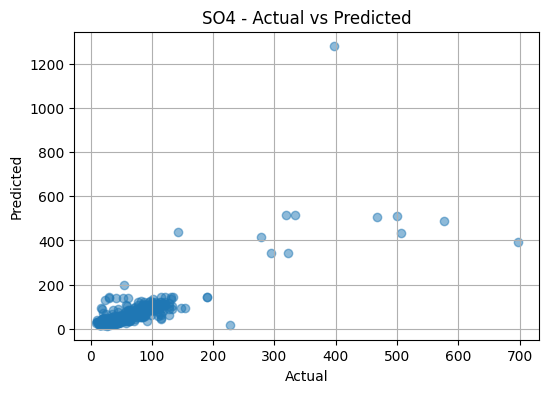

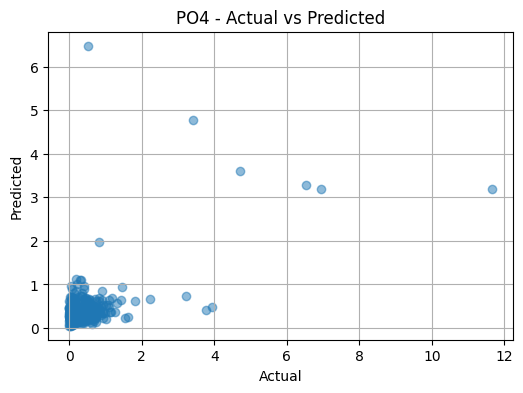

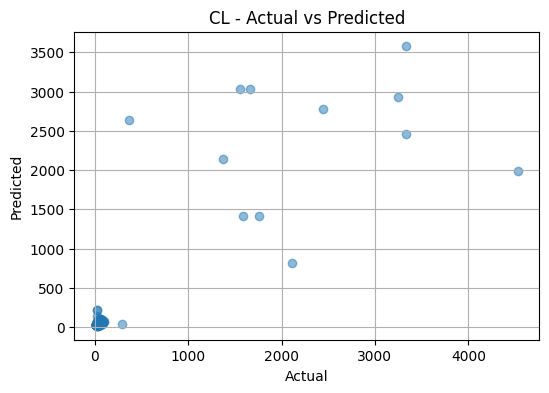

In [10]:
# FINAL PROJECT - Water Quality Prediction (Polished Version)

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load and prepare data
df = pd.read_csv("water_quality.csv", sep=';')
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df = df.sort_values(by=['id', 'date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
pollutants = ['O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']
df = df.dropna(subset=pollutants)

# Features/Targets
X = df[['id', 'year']]
y = df[pollutants]
X_encoded = pd.get_dummies(X, columns=['id'], drop_first=True)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42)

# Train model
model = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
for i, pollutant in enumerate(pollutants):
    print(f"{pollutant}: MSE = {mean_squared_error(y_test.iloc[:, i], y_pred[:, i]):.2f}, R2 = {r2_score(y_test.iloc[:, i], y_pred[:, i]):.2f}")

# Save model
joblib.dump(model, "pollution_model.pkl")
joblib.dump(X_encoded.columns.tolist(), "model_columns.pkl")

# Define reusable prediction function
def predict_pollutants(station_id, year_input):
    input_data = pd.DataFrame({'year': [year_input], 'id': [station_id]})
    input_encoded = pd.get_dummies(input_data, columns=['id'])
    for col in X_encoded.columns:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    input_encoded = input_encoded[X_encoded.columns]
    result = model.predict(input_encoded)[0]
    return dict(zip(pollutants, result))

# Make prediction
result = predict_pollutants(22, 2024)
print("\n🌍 Predicted Pollutant Levels:")
for p, v in result.items():
    print(f"{p}: {v:.2f}")

# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df[pollutants].corr(), annot=True, cmap='coolwarm')
plt.title("Pollutant Correlation Heatmap")
plt.show()

# Actual vs Predicted Plot
for i, pollutant in enumerate(pollutants):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5)
    plt.title(f"{pollutant} - Actual vs Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.show()
